In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy import interpolate 
import os

# llops imports
import llops as yp
import llops.simulation as sim

# Comptic imports
import comptic

# DPC analysis function
import pydpc

# Set backend and dtype for llops
yp.setDefaultBackend('numpy')
yp.setDefaultDatatype('float32')

# Directory to save figures
output_dir = os.path.expanduser('~/Desktop')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Object

<IPython.core.display.Javascript object>


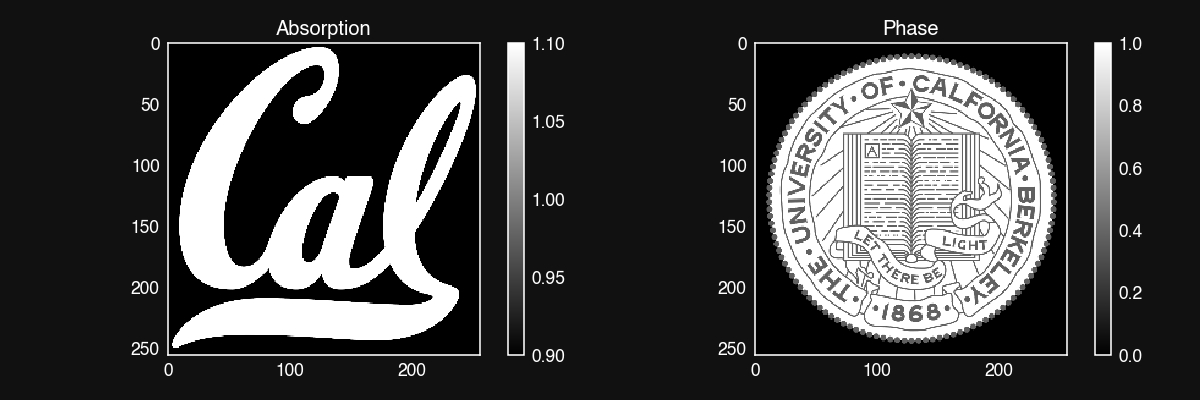

In [3]:
# Define object shape
object_shape = (256, 256)
# object_shape = (16, 16)

# Define complex object (field)
field = sim.ucb(object_shape)

# Get amplitude and phase
amp, phase = np.abs(field), np.angle(field)

# Plot
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(field), cmap = 'gray')
plt.title('Absorption')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(field), cmap = 'gray')
plt.title('Phase')
plt.colorbar()
plt.tight_layout()

## Get System Parameters 

In [4]:
led_positions = comptic.ledarray.getPositionsNa('quasi-dome')

# Get remaining system parameters
system_parameters = pydpc.getDefaultSystemParams(system_magnification=2,
                                             illumination_source_position_list_na=led_positions)

# Defining a Source Using LED Positions

## Generate DPC Source Positions

<IPython.core.display.Javascript object>


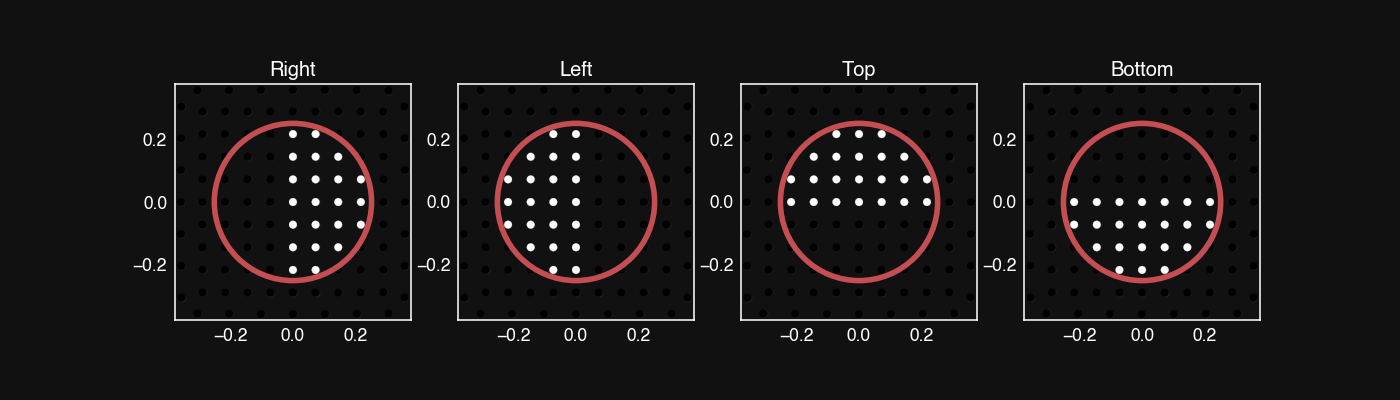

In [5]:
# Generate LED patterns
source_names = ['Right', 'Left', 'Top', 'Bottom']
dpc_led_pattern_list = pydpc.genDpcSourcePositionList(dpc_type_list=source_names, **system_parameters)

# Show patterns
pydpc.plotSourcePositionList(dpc_led_pattern_list, labels=source_names, **system_parameters)

## Show WOTFs

<IPython.core.display.Javascript object>


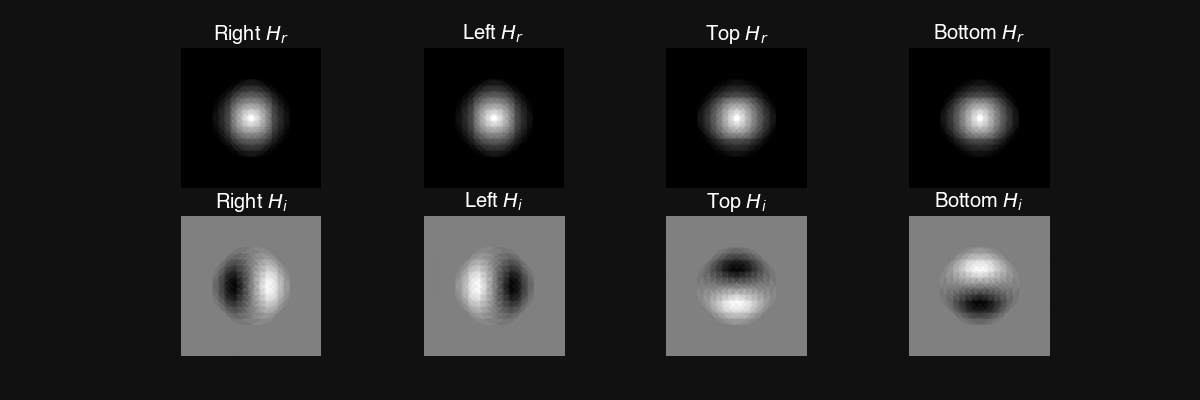

In [6]:
# Generate corresponding WOTFs
Hr_list, Hi_list = pydpc.genWotfsFromSourcePositionList(object_shape, dpc_led_pattern_list, **system_parameters )

# Show WOTFs
pydpc.plotWotfList(Hr_list, Hi_list, labels=source_names)

## Generate Nonlinear Measurements from Source Positions

<IPython.core.display.Javascript object>


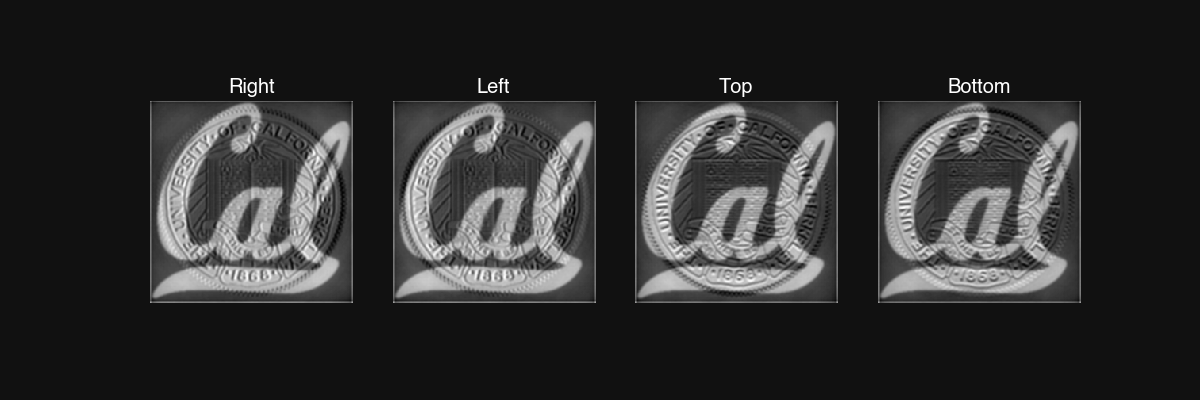

In [7]:
# Generate Intensities
measurement_list = [pydpc.genMeasurementNonLinear(field, dpc_pattern, **system_parameters) for dpc_pattern in dpc_led_pattern_list]

# Show result
yp.listPlotFlat(measurement_list, source_names)

## Generate Linear Measurements from Source Positions

<IPython.core.display.Javascript object>


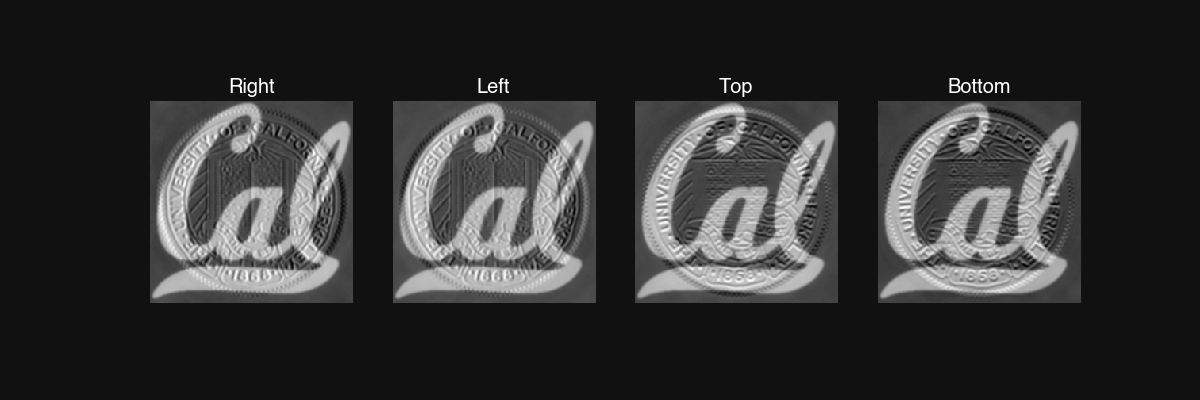

In [8]:
## Generate DPC patterns
intensity_list = pydpc.genMeasurementsLinear(field, dpc_led_pattern_list, **system_parameters)

# Print intensity
yp.listPlotFlat(intensity_list, source_names)

# Using a Continuous Source

<IPython.core.display.Javascript object>


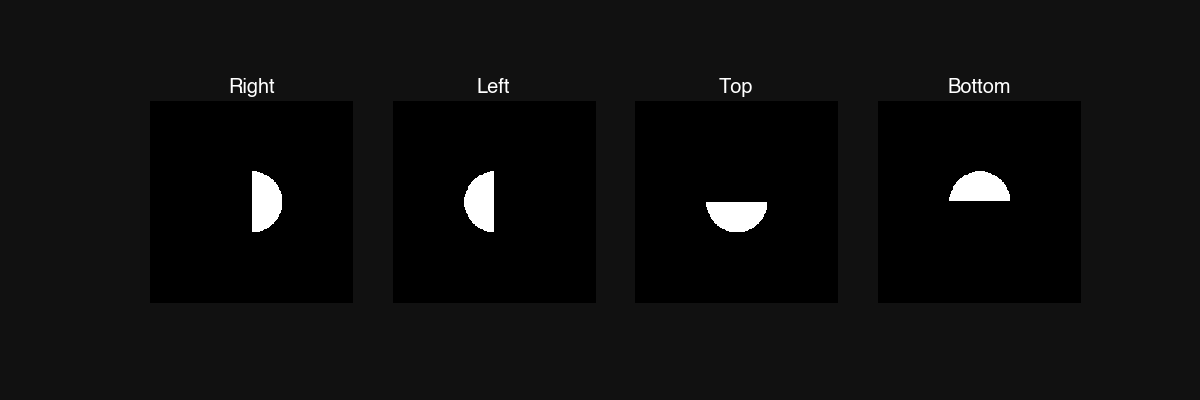

In [16]:
# Generate LED patterns
source_names = ['Right', 'Left', 'Top', 'Bottom']
dpc_source_list_continuous = pydpc.genDpcSourceList(object_shape, dpc_type_list=source_names, **system_parameters)

# Show patterns
yp.listPlotFlat(dpc_source_list_continuous, source_names)

## Generate WOTFs

<IPython.core.display.Javascript object>


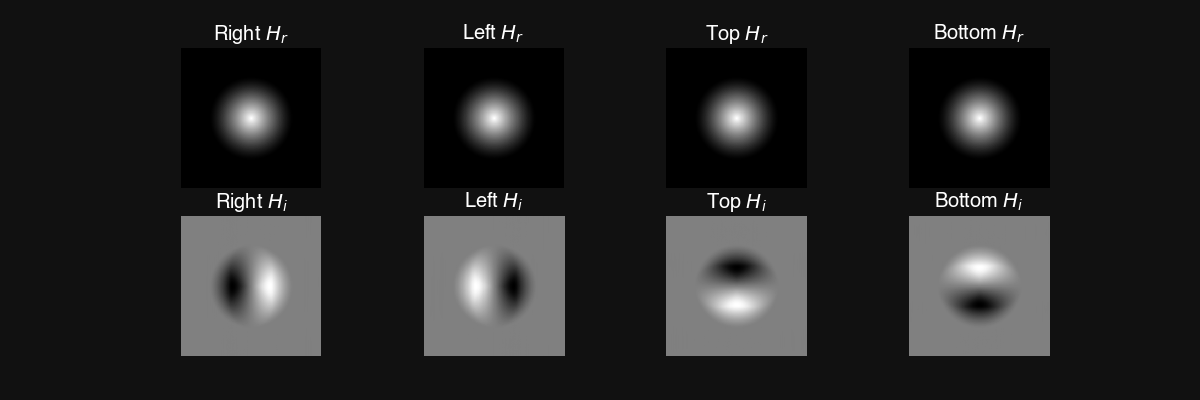

In [17]:
# Generate corresponding WOTFs
Hr_list, Hi_list = pydpc.genWotfsFromSourceList(dpc_source_list_continuous, **system_parameters )

# Show WOTFs
pydpc.plotWotfList(Hr_list, Hi_list, labels=source_names)

# Calculate Estimated SNR of Measurements

In [18]:
# Define illuminance at sample per LED
per_led_illuminance = 1000

# Determine total illuminance for each pattern
total_pattern_illuminance = [per_led_illuminance * yp.sum(dpc_pattern) for dpc_pattern in dpc_led_pattern_list]

# Determine photon pixel rate
photon_pixel_rate_list = [pydpc.analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters) for illuminance in total_pattern_illuminance]

# Define Exposure time
exposure_time = 0.01

# Determine measurement SNR
snr_list = [pydpc.analysis.photonPixelRateToSnr(photon_pixel_rate, exposure_time, **system_parameters) for photon_pixel_rate in photon_pixel_rate_list]
print(snr_list)

[137.32522037864427, 137.32522037864427, 137.32522037864427, 137.32522037864427]


## Add SNR to Measurements

<IPython.core.display.Javascript object>


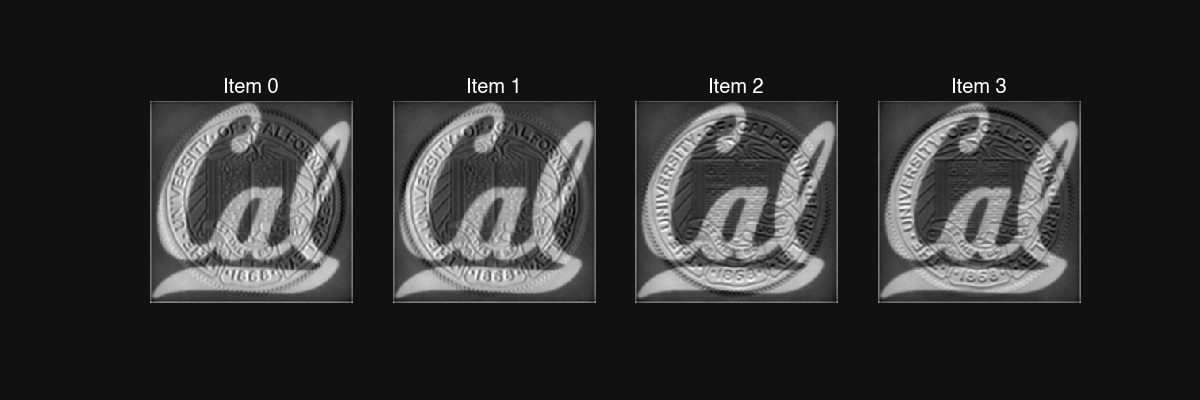

In [19]:
# Add noise to measurements
measurement_list_noisy = [comptic.noise.add(measurement, type='gaussian', snr=snr) for measurement, snr in zip(measurement_list, snr_list)]

# Show noisy measurements
yp.listPlotFlat(measurement_list_noisy)

## Generate WOTFs from LED Positions

<IPython.core.display.Javascript object>


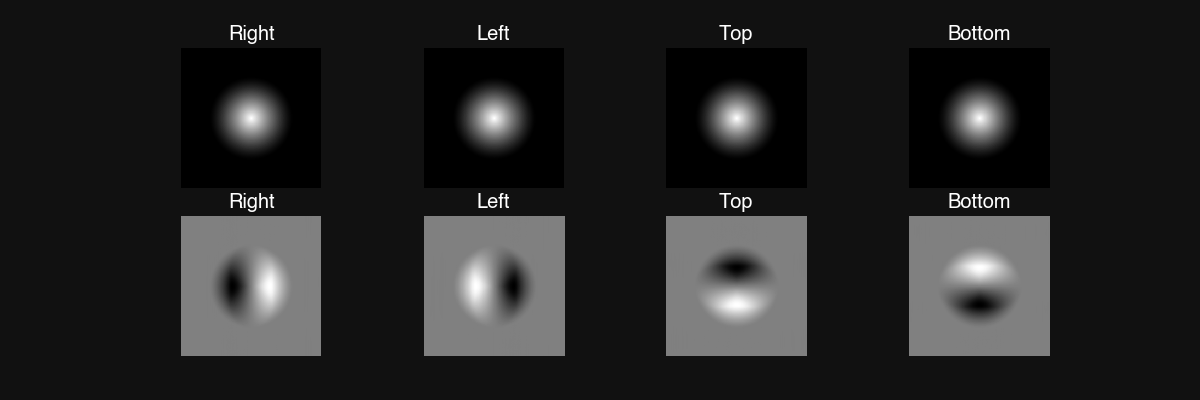

In [21]:
# Generate source list
source_list = pydpc.genDpcSourceList(object_shape, ['right', 'left', 'top', 'bottom'], **system_parameters)

# Generate Hr and Hi from source list
Hr_list, Hi_list = pydpc.genWotfsFromSourceList(source_list, **system_parameters)

# Show WOTFs
yp.listPlotFlat(Hr_list + [yp.imag(Hi) for Hi in Hi_list], source_names + source_names, max_width=4)

## Generate WOTFs from Source Position List

<IPython.core.display.Javascript object>


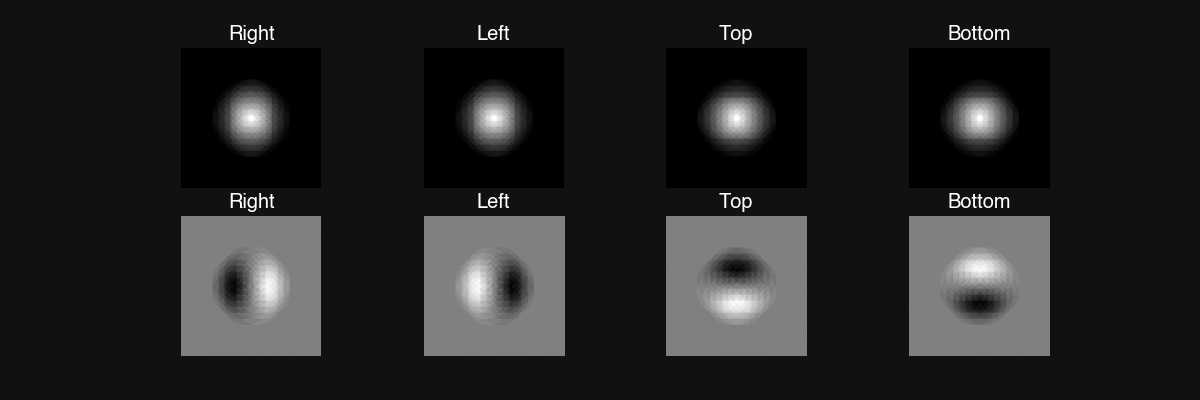

In [23]:
# Generate Hr and Hi from source list
Hr_list, Hi_list = pydpc.genWotfsFromSourcePositionList(object_shape, dpc_led_pattern_list, **system_parameters)

# Show WOTFs
yp.listPlotFlat(Hr_list + [yp.imag(Hi) for Hi in Hi_list], source_names + source_names, max_width=4)

## Calculate WOTF Support

<IPython.core.display.Javascript object>


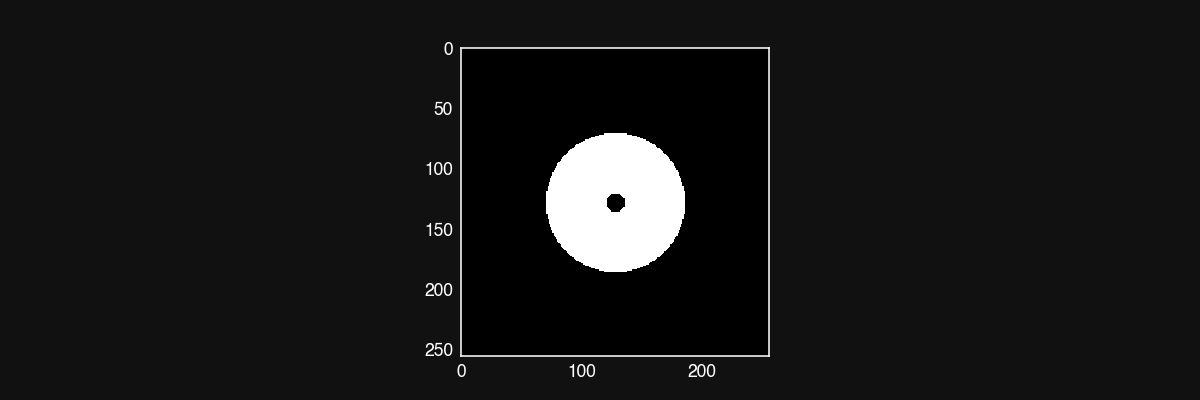

In [24]:
# Define mask size
minimum_na = 0.05
maximum_na = system_parameters['objective_numerical_aperture'] * 1.5

# Generate mask
support = pydpc.analysis.supportMask(object_shape, min_na=minimum_na, max_na=maximum_na, **system_parameters)

# Plot result
plt.figure()
plt.imshow(support)

## Normalize Measurements

In [25]:
measurement_list_normalized = [measurement / yp.mean(measurement) - 1.0 for measurement in measurement_list_noisy]

## Perform DPC Inversion

<IPython.core.display.Javascript object>


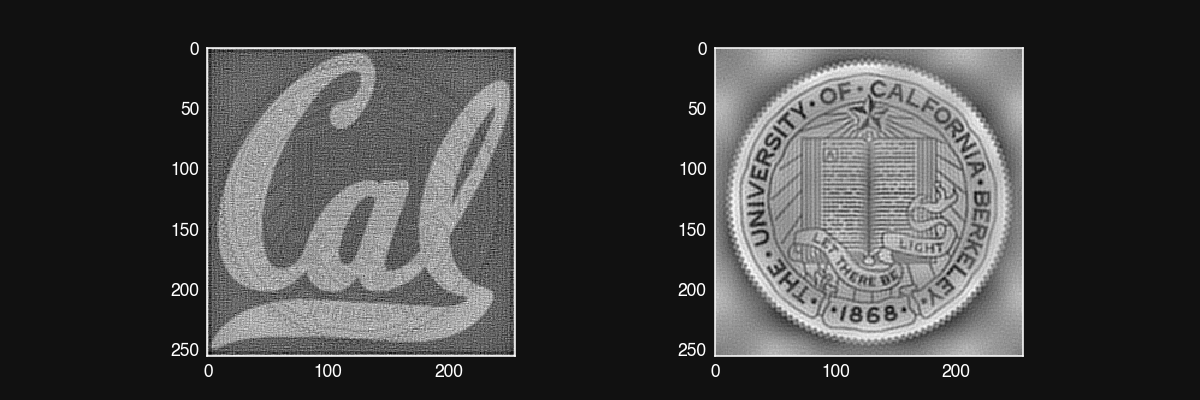

In [26]:
field_recovered = pydpc.invert(measurement_list_normalized, Hr_list, Hi_list, reg_imag=1e-8, reg_real=1e-8)

plt.figure()
plt.subplot(121)
plt.imshow(yp.real(field_recovered))
plt.subplot(122)
plt.imshow(yp.imag(field_recovered))